In [ ]:
pip install lightgbm


In [4]:


import lightgbm as lgb
import pandas as pd


In [5]:
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis



df = pd.read_csv(r"C:\Users\AKASH\OneDrive\Desktop\phase2\DATASET_25_s.csv")




def calculate_aac(sequence):
    # Calculate Amino Acid Composition (AAC)
    protein_analysis = ProteinAnalysis(sequence)
    aac = protein_analysis.get_amino_acids_percent()
    return aac
def calculate_k_spaced_pairs(sequence, k):
    # Calculate k-spaced amino acid pairs
    pairs = {}
    length = len(sequence)
    for i in range(length - k):
        pair = sequence[i] + sequence[i + k]
        if pair in pairs:
            pairs[pair] += 1
        else:
            pairs[pair] = 1
    return pairs

def calculate_pse_aac_type_ii(sequence, k, max_length):
    aac = calculate_aac(sequence)
    pairs = calculate_k_spaced_pairs(sequence, k)

    # Calculate dipeptide composition
    dipeptides = [sequence[i:i+2] for i in range(len(sequence)-1)]
    dipeptide_counts = {dipeptide: dipeptides.count(dipeptide) for dipeptide in set(dipeptides)}

    pse_aac = list(aac.values())
    for pair_count in pairs.values():
        pse_aac.append(pair_count)

    # Add dipeptide counts to PseAAC
    for dipeptide in sorted(dipeptide_counts.keys()):
        pse_aac.append(dipeptide_counts[dipeptide])

    # Pad or truncate pse_aac to max_length
    if len(pse_aac) < max_length:
        pse_aac.extend([0] * (max_length - len(pse_aac)))
    elif len(pse_aac) > max_length:
        pse_aac = pse_aac[:max_length]

    return np.array(pse_aac)


def encode_sequences_in_dataframe2(df, sequence_column, k, max_length):
    encoded_sequences = []
    for i, row in df.iterrows():
        sequence = row[sequence_column]
        pse_aac = calculate_pse_aac_type_ii(sequence, k, max_length)
        encoded_sequences.append(pse_aac)
    return np.array(encoded_sequences)
k = 3
max_length = 3601
encoded_sequences_1 = encode_sequences_in_dataframe2(df, "Sequence", k, max_length)
encoded_sequences_2 = encode_sequences_in_dataframe2(df, "Sequence_Interacts_With", k, max_length) 


print("Shape of encoded sequences array:", encoded_sequences_1.shape)
print("Shape of encoded interacting sequences array:", encoded_sequences_2.shape)

df['Label'] = df['Interacts with'].apply(lambda x: 1 if pd.notna(x) else 0)

df.to_csv("labeled_dataset.csv", index=False)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


feature_matrix= np.concatenate((encoded_sequences_1, encoded_sequences_2), axis=1)

# Print the shape of the concatenated array
print("Shape of feature_matrix:", feature_matrix.shape)
target_labels = df['Label'].values


X_train, X_test_, y_train, y_test_ = train_test_split(feature_matrix, target_labels, test_size=0.2, random_state=42)



Shape of encoded sequences array: (5294, 3601)
Shape of encoded interacting sequences array: (5294, 3601)
Shape of feature_matrix: (5294, 7202)


In [44]:
PPI_clf_L = lgb.LGBMClassifier()

PPI_clf_L  = lgb.LGBMClassifier(learning_rate=0.1, 
                         max_depth=10, 
                         num_leaves=65, 
                         n_estimators=100,
                         force_row_wise=True)



In [45]:
PPI_clf_L.fit(X_train, y_train)
y_pred_ = PPI_clf_L.predict(X_test_)
accuracy1 = accuracy_score(y_test_, y_pred_)
print("Accuracy :", accuracy1)

[LightGBM] [Info] Number of positive: 2134, number of negative: 2101
[LightGBM] [Info] Total Bins 31884
[LightGBM] [Info] Number of data points in the train set: 4235, number of used features: 1488
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503896 -> initscore=0.015585
[LightGBM] [Info] Start training from score 0.015585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [6]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test_, y_pred_, average='binary')  # Adjust 'binary' for multi-class classification

print(f"F1 Score: {f1}")

F1 Score: 0.7322834645669292


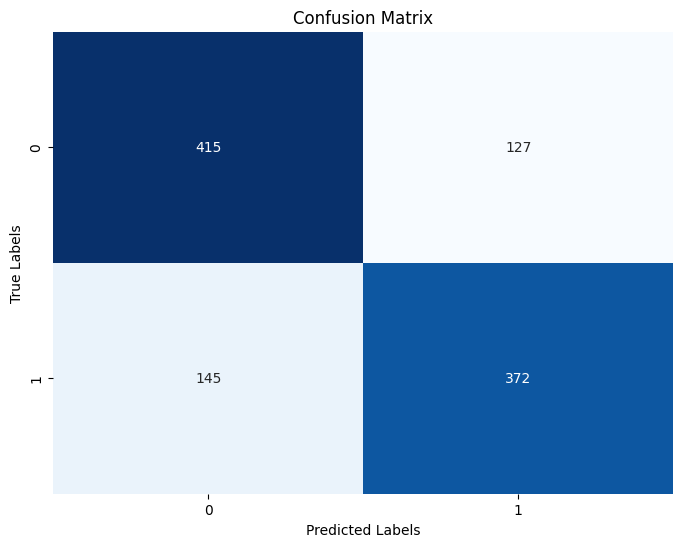

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test_, y_pred_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [8]:
y_pred_prob = PPI_clf_L.predict_proba(X_test_)[:, 1]

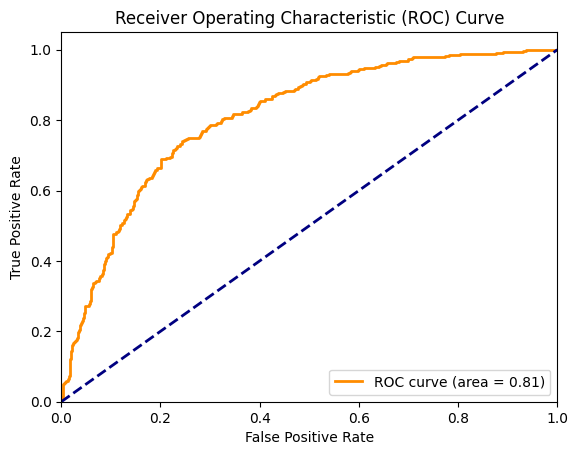

In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt

# Example: Load your dataset
# X, y = load_your_data()

# Split the data into training and validation sets
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the XGBoost model



# Get the predicted probabilities





# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

{'0': {'precision': 0.7410714285714286, 'recall': 0.7656826568265682, 'f1-score': 0.7531760435571688, 'support': 542.0}, '1': {'precision': 0.7454909819639278, 'recall': 0.7195357833655706, 'f1-score': 0.7322834645669292, 'support': 517.0}, 'accuracy': 0.7431539187913125, 'macro avg': {'precision': 0.7432812052676783, 'recall': 0.7426092200960694, 'f1-score': 0.742729754062049, 'support': 1059.0}, 'weighted avg': {'precision': 0.7432290386790037, 'recall': 0.7431539187913125, 'f1-score': 0.7429763614627836, 'support': 1059.0}}


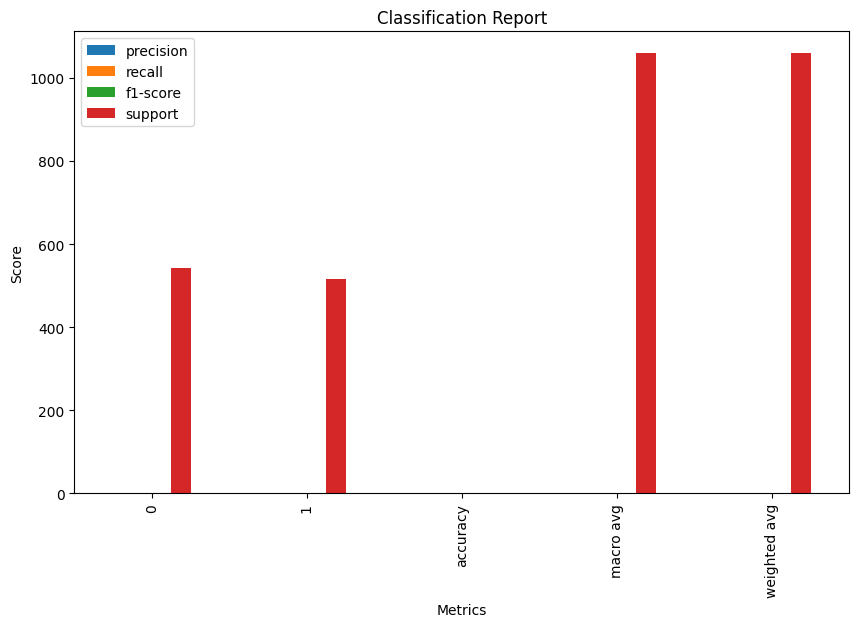

In [10]:





from sklearn.metrics import classification_report

# Get classification report
y_pred_r = PPI_clf_L.predict(X_test_)
report = classification_report(y_test_, y_pred_r, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report)

# Plot classification report
report_df.plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.show()


In [11]:
report_dict = report

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Print the classification report as a table
print(report_df)

              precision    recall  f1-score      support
0              0.741071  0.765683  0.753176   542.000000
1              0.745491  0.719536  0.732283   517.000000
accuracy       0.743154  0.743154  0.743154     0.743154
macro avg      0.743281  0.742609  0.742730  1059.000000
weighted avg   0.743229  0.743154  0.742976  1059.000000


feature selection

PPI_clf_L2 .fit(X_train_pca, y_train)
feature_importances = PPI_clf_L2.feature_importances_

In [29]:
PPI_clf_L2 .fit(X_train_pca, y_train)
feature_importances = PPI_clf_L2.feature_importances_

[LightGBM] [Info] Number of positive: 2134, number of negative: 2101
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 4235, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503896 -> initscore=0.015585
[LightGBM] [Info] Start training from score 0.015585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [47]:
PPI_clf_L2 .fit(X_train, y_train)
feature_importances = PPI_clf_L2.feature_importances_

[LightGBM] [Info] Number of positive: 2134, number of negative: 2101
[LightGBM] [Info] Total Bins 31884
[LightGBM] [Info] Number of data points in the train set: 4235, number of used features: 1488
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503896 -> initscore=0.015585
[LightGBM] [Info] Start training from score 0.015585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [30]:
feature_names = np.arange(X_train_pca.shape[1])
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})


In [48]:
feature_names = np.arange(X_train.shape[1])
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

In [49]:
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [50]:
#dimn redud
print(importance_df.head(20))

      Feature  Importance
0           0          97
11         11          91
3601     3601          90
13         13          81
15         15          80
3606     3606          76
3612     3612          73
7           7          71
14         14          68
3609     3609          67
3608     3608          66
3602     3602          65
3615     3615          64
3604     3604          64
3610     3610          64
3607     3607          64
5           5          62
3619     3619          60
3618     3618          57
3616     3616          55


In [15]:
print(importance_df.head(20))

      Feature  Importance
0           0          97
11         11          91
3601     3601          90
13         13          81
15         15          80
3606     3606          76
3612     3612          73
7           7          71
14         14          68
3609     3609          67
3608     3608          66
3602     3602          65
3615     3615          64
3604     3604          64
3610     3610          64
3607     3607          64
5           5          62
3619     3619          60
3618     3618          57
3616     3616          55


In [51]:
N = 100  # Set N to the number of top features you want to keep
top_n_features = importance_df['Feature'].iloc[:N].values

#joblib.dump(top_n_features, 'top_n_features.pkl')

In [34]:
#dr
N = 100  # Set N to the number of top features you want to keep
top_n_features2 = importance_df['Feature'].iloc[:N].values


In [18]:
import pickle

# Assume importance_df is your DataFrame with feature importances
top_n_features = importance_df['Feature'].iloc[:N].values

# Save the top N features to a file
with open('top_n_features.pkl', 'wb') as f:
    pickle.dump(top_n_features, f)


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt

# Example: Load your dataset
# X, y = load_your_data()

# Split the data into training and validation sets
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the XGBoost model



# Get the predicted probabilities





# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve ')
plt.legend(loc="lower right")
plt.show()

In [57]:

X_train_selected = X_train[:, top_n_features]
X_test_selected = X_test_[:, top_n_features]

X_train_selected = X_train_pca[:, top_n_features2]
X_test_selected = X_test_pca[:, top_n_features2]

In [42]:

X_train_selected2 = X_train_pca[:, top_n_features2]
X_test_selected2 = X_test_pca[:, top_n_features2]

In [6]:
PPI_clf_L2 = lgb.LGBMClassifier(learning_rate=0.1, 
                                        max_depth=10, 
                                        num_leaves=65, 
                                        n_estimators=100,
                                        force_row_wise=True)

In [21]:
PPI_clf_L.fit(X_train_selected, y_train)
y_pred_selected = PPI_clf_L.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test_, y_pred_selected)
print("Accuracy with selected features:", accuracy_selected)

[LightGBM] [Info] Number of positive: 2134, number of negative: 2101
[LightGBM] [Info] Total Bins 11241
[LightGBM] [Info] Number of data points in the train set: 4235, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503896 -> initscore=0.015585
[LightGBM] [Info] Start training from score 0.015585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [21]:
#dimensinality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test_)

In [66]:
PPI_clf_Ld = lgb.LGBMClassifier(learning_rate=0.1, 
                                        max_depth=10, 
                                        num_leaves=65, 
                                        n_estimators=100,
                                        force_row_wise=True)

In [68]:
PPI_clf_Ld.fit(X_train_pca, y_train)
y_pred_pca = PPI_clf_Ld.predict(X_test_pca)
accuracy_p = accuracy_score(y_test_, y_pred_pca)
print("Accuracy with selected features:", accuracy_p)

[LightGBM] [Info] Number of positive: 2134, number of negative: 2101
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 4235, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503896 -> initscore=0.015585
[LightGBM] [Info] Start training from score 0.015585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [ ]:
y_pred_prop = PPI_clf_L2.predict_proba(X_test_pca)[:, 1]

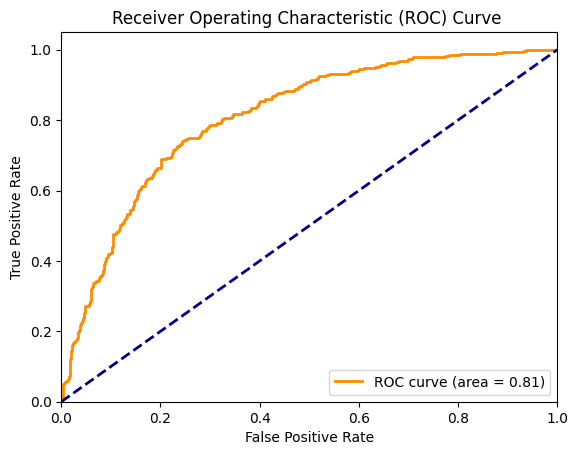

In [65]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt

# Example: Load your dataset
# X, y = load_your_data()

# Split the data into training and validation sets
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the XGBoost model



# Get the predicted probabilities



#roc with after dimensinality reduction

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_, y_pred_prop)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve ')
plt.legend(loc="lower right")
plt.show()

parameter tuning

In [ ]:
from sklearn.model_selection import  GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 20, 30],
    'num_leaves': [31, 63, 127],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm = lgb.LGBMClassifier(force_row_wise=True)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2134, number of negative: 2101
[LightGBM] [Info] Total Bins 11241
[LightGBM] [Info] Number of data points in the train set: 4235, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503896 -> initscore=0.015585
[LightGBM] [Info] Start training from score 0.015585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 30, 'n_estimators': 200, 'num_leaves': 100, 'subsample': 0.8}
[LightGBM] [Info] Number of positive: 2134, number of negative: 2101
[LightGBM] [Info] Total Bins 11241
[LightGBM] [Info] Number of data points in the train set: 4235, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503896 -> initscore=0.015585
[LightGBM] [Info] Start training from score 0.015585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy with best hyperparameters: 0.7507082152974505


In [37]:
Best_model = lgb.LGBMClassifier(colsample_bytree =1.0,
                                       learning_rate=0.1, 
                                        max_depth=20,
                                        min_child_samples =30, 
                                        num_leaves=100,
                                        subsample = 0.8, 
                                        n_estimators=200,
                                        force_row_wise=True)

In [25]:
Accuracy_p = 0.7507082152974505

In [58]:
Best_model.fit(X_train_selected, y_train)
y_pred_l = Best_model.predict(X_test_selected)
accuracyb = accuracy_score(y_test_, y_pred_l)
print("Accuracy with best parameter:", accuracyb)

[LightGBM] [Info] Number of positive: 2134, number of negative: 2101
[LightGBM] [Info] Total Bins 11241
[LightGBM] [Info] Number of data points in the train set: 4235, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503896 -> initscore=0.015585
[LightGBM] [Info] Start training from score 0.015585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [59]:
from sklearn.metrics import f1_score
f1_b = f1_score(y_test_, y_pred_l, average='binary')  # Adjust 'binary' for multi-class classification

print(f"F1 Score: {f1_b}")

F1 Score: 0.7471264367816092


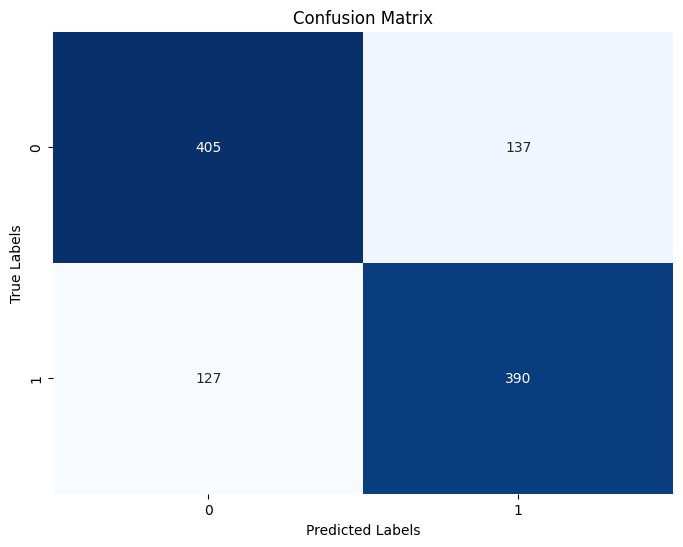

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test_, y_pred_l)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
y_pred_l_prob = Best_model.predict_proba(X_test_selected)[:, 1]

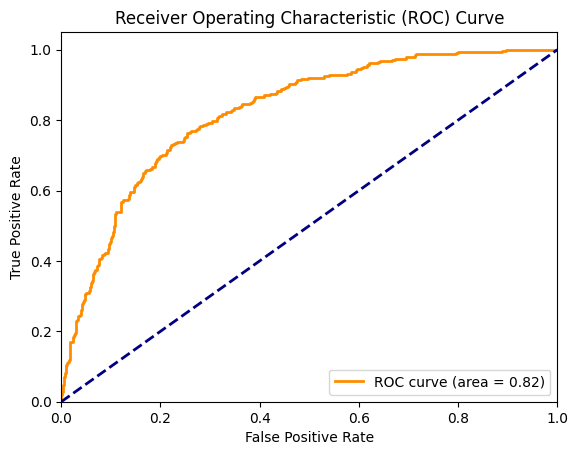

In [31]:
fpr, tpr, thresholds = roc_curve(y_test_, y_pred_l_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

{'0': {'precision': 0.7410714285714286, 'recall': 0.7656826568265682, 'f1-score': 0.7531760435571688, 'support': 542.0}, '1': {'precision': 0.7454909819639278, 'recall': 0.7195357833655706, 'f1-score': 0.7322834645669292, 'support': 517.0}, 'accuracy': 0.7431539187913125, 'macro avg': {'precision': 0.7432812052676783, 'recall': 0.7426092200960694, 'f1-score': 0.742729754062049, 'support': 1059.0}, 'weighted avg': {'precision': 0.7432290386790037, 'recall': 0.7431539187913125, 'f1-score': 0.7429763614627836, 'support': 1059.0}}


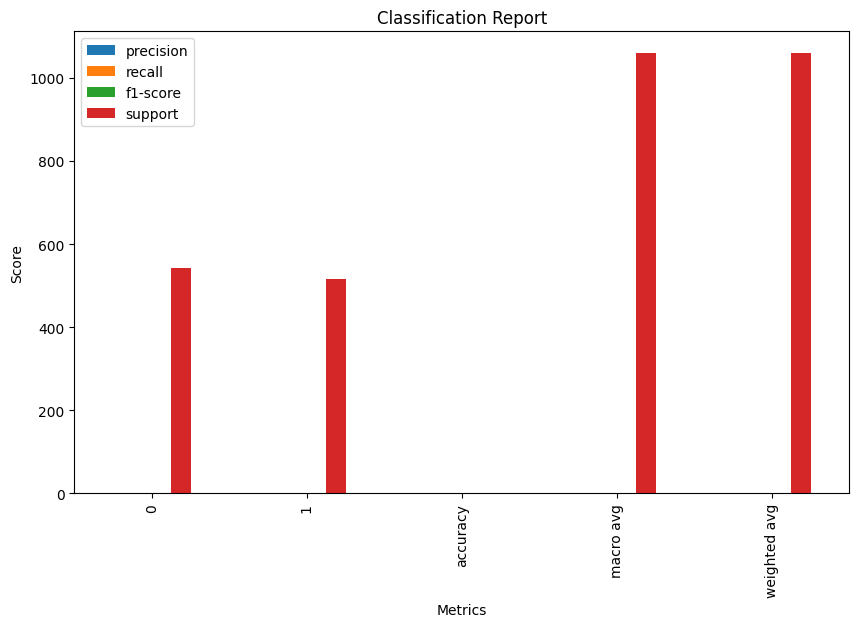

              precision    recall  f1-score      support
0              0.761278  0.747232  0.754190   542.000000
1              0.740038  0.754352  0.747126   517.000000
accuracy       0.750708  0.750708  0.750708     0.750708
macro avg      0.750658  0.750792  0.750658  1059.000000
weighted avg   0.750909  0.750708  0.750742  1059.000000


In [32]:
from sklearn.metrics import classification_report

# Get classification report
y_pred_l = Best_model.predict(X_test_selected)
report2 = classification_report(y_test_, y_pred_l, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report)

# Plot classification report
report_df.plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.show()

report_dict = report2

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Print the classification report as a table
print(report_df)

In [33]:
import joblib
joblib.dump(Best_model, 'Final Model.pkl')

['Final Model.pkl']

In [43]:
Best_model.fit(X_train_selected2, y_train)
y_pred_l = Best_model.predict(X_test_selected2)
accuracy_d = accuracy_score(y_test_, y_pred_l)
print("Accuracy with reduced parameter:", accuracy_d)

[LightGBM] [Info] Number of positive: 2134, number of negative: 2101
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 4235, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503896 -> initscore=0.015585
[LightGBM] [Info] Start training from score 0.015585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

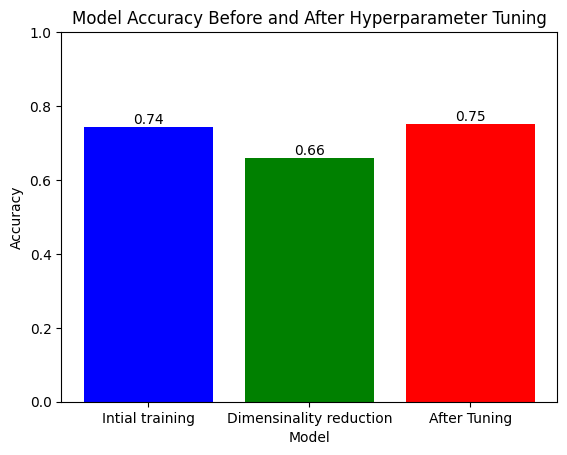

In [63]:
import matplotlib.pyplot as plt


labels = ['Intial training', 'Dimensinality reduction', 'After Tuning']
accuracies = [accuracy1, accuracy_d, accuracyb]

plt.bar(labels, accuracies, color=['blue', 'green','red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Before and After Hyperparameter Tuning')
plt.ylim(0, 1)  # Ensure the y-axis is in the range [0, 1]
for i in range(len(accuracies)):
    plt.text(i, accuracies[i] + 0.01, f'{accuracies[i]:.2f}', ha='center')
plt.show()